# Table of Content

<a name="outline"></a>

## Setup

- [A](#seca) External Imports
- [B](#secb) Internal Imports
- [C](#secd) Configurations and Paths 
- [D](#sece) Patient Interface and Train/Val/Test Partitioning


## Evaluations

- [1](#sec2) Predictive Performance: MIMIC-III (Test Set)
- [2](#sec3) Predictive Performance: MIMIC-IV (Test Set)
- [3](#sec4) Predictive Performance: from MIMIC-IV (Training Set) to MIMIC-III (All)

<a name="seca"></a>

### A External Imports [^](#outline)

In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from IPython.display import display
from upsetplot import from_contents, plot, UpSet, from_indicators


<a name="secb"></a>

### B Internal Imports [^](#outline)

In [2]:
# HOME and DATA_STORE are arbitrary, change as appropriate.
HOME = os.environ.get('HOME')
DATA_STORE = f'{HOME}/GP/ehr-data'



%load_ext autoreload
%autoreload 2

import analysis as A
import common as C



/home/asem/anaconda3/envs/mlhc-env/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


<a name="secc"></a>

### C Configurations and Paths [^](#outline)

In [3]:
mimic_dir = {
    'M3': f'{DATA_STORE}/mimic3-transforms',
    'M4': f'{DATA_STORE}/mimic4-transforms'
}

The following cell configures the location of the models pretrained on MIMIC-III (M3) and MIMIC-IV (M4), with GRAM embeddings (G) and without. Each training experiment produces 100 parameters snapshot and this Notebook picks the one that maximizes the average AUC of the visit level (prob. of having higher risks for present codes than the absent codes of the same visit).

To download our own experiment files and proceed with the analysis in this Notebook, without having to run any training, send an email to (`asem.a.abdelaziz@imperial.ac.uk`) to have access to a copy of these files (size: `5.1 GB`). 

In [4]:
train_dir = {
    # Location of training experiments on MIMIC-III without GRAM embeddings (simple Matrix embeddings).
    'M3': f'{DATA_STORE}/icenode-m3-exp/train_config_v0.2.25_M3',
    # Location of training experiments on MIMIC-III with GRAM embeddings.
    'GM3': f'{DATA_STORE}/icenode-m3-exp/train_config_v0.2.25_G_M3',
    # Location of training experiments on MIMIC-IV without GRAM embeddings (simple Matrix embeddings).
    'M4': f'{DATA_STORE}/icenode-m4-exp/train_config_v0.2.25_M4',
    # Location of training experiments on MIMIC-IV with GRAM embeddings.
    'GM4': f'{DATA_STORE}/icenode-m4-exp/train_config_v0.2.25_G_M4'
}

In [5]:
# Subdirectory names in `train_dir` corresponding to each model
model_dir = {
    'ICE-NODE': 'icenode_2lr',
    'ICE-NODE_UNIFORM': 'icenode_uniform2lr',
    'GRU': 'gru',
    'RETAIN': 'retain',
    'LogReg': 'window_logreg'
}

In [6]:
clfs = list(model_dir.keys())

relative_auc_config = {
    'pvalue': 0.01, 
    'min_auc': 0.9
}
top_k_list=[1, 2, 3, 5, 7, 10, 15, 20]
percentile_range=20 
n_percentiles=int(100/percentile_range)


import matplotlib.font_manager as font_manager
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'font.family': 'sans-serif',
                     'font.sans-serif': 'Helvetica',
                     'font.weight':  'normal'})

In [7]:
output_dir = 'artefacts'
Path(output_dir).mkdir(parents=True, exist_ok=True)


<a name="secd"></a>

### D Patient Interface and Train/Val/Test Patitioning [^](#outline)

In [8]:
m4_interface = C.create_patient_interface(mimic_dir['M4'])
m3_interface = C.create_patient_interface(mimic_dir['M3'])

m4_train_ids, m4_valid_ids, m4_test_ids = m4_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)
m3_train_ids, m3_valid_ids, m3_test_ids = m3_interface.random_splits(split1=0.7, split2=0.85, random_seed=42)

In [9]:
m4_percentiles = m4_interface.dx_flatccs_by_percentiles(percentile_range)
m3_percentiles = m3_interface.dx_flatccs_by_percentiles(percentile_range)

m4_train_percentiles = m4_interface.dx_flatccs_by_percentiles(percentile_range, m4_train_ids)
m3_train_percentiles = m3_interface.dx_flatccs_by_percentiles(percentile_range, m3_train_ids)

<a name="sec1"></a>

## 1 Snooping/Selecting Best Models from the Validation Set [^](#outline)

In [10]:
# Classifiers with Linear Embeddings
clfs = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU',
    'RETAIN',
    'LogReg'
)

# Classifiers with GRAM Embeddings
clfs_G = (
    'ICE-NODE', 
    'ICE-NODE_UNIFORM',
    'GRU'
)

In [11]:
print('> Models trained on MIMIC-III')
m3_top = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M3', 
                               criterion='MICRO-AUC',  comp=max)
display(m3_top['summary'])

print('> Models trained on MIMIC-IV')
m4_top = A.get_trained_models(clfs=clfs, train_dir=train_dir, model_dir=model_dir, data_tag='M4', 
                               criterion='MICRO-AUC',  comp=max)
display(m4_top['summary'])


print('> Models (GRAM) trained on MIMIC-III')
gm3_top = A.get_trained_models(clfs=clfs_G, train_dir=train_dir, model_dir=model_dir, data_tag='GM3',  
                                criterion='MICRO-AUC', comp=max)
display(gm3_top['summary'])

print('> Models (GRAM) trained on MIMIC-IV')
gm4_top = A.get_trained_models(clfs=clfs_G, train_dir=train_dir, model_dir=model_dir, data_tag='GM4', 
                                criterion='MICRO-AUC', comp=max)
display(gm4_top['summary'])


> Models trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,57,0.925790
1,ICE-NODE_UNIFORM,44,0.925757
2,GRU,32,0.923570
3,RETAIN,20,0.927307
4,LogReg,0,0.912001


> Models trained on MIMIC-IV


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,38,0.933961
1,ICE-NODE_UNIFORM,66,0.932462
2,GRU,15,0.936528
3,RETAIN,17,0.936482
4,LogReg,0,0.891420


> Models (GRAM) trained on MIMIC-III


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,58,0.924722
1,ICE-NODE_UNIFORM,58,0.924760
2,GRU,32,0.923149


> Models (GRAM) trained on MIMIC-IV


,Clf,Best_i,MICRO-AUC
0,ICE-NODE,41,0.934028
1,ICE-NODE_UNIFORM,29,0.932499
2,GRU,17,0.936749


In [12]:

m3_models = C.get_models(clfs, m3_top["config"], m3_top["params"], m3_interface)
gm3_models = C.get_models(clfs_G, gm3_top["config"], gm3_top["params"], m3_interface)

m4_models = C.get_models(clfs, m4_top["config"], m4_top["params"], m4_interface)
gm4_models = C.get_models(clfs_G, gm4_top["config"], gm4_top["params"], m4_interface)

In [16]:
m3_models['GRU'].keys()

AttributeError: 'tuple' object has no attribute 'keys'

In [17]:
def cross_predictor(clf, source_tag, target_tag):
    if '/G' in clf:
        clf = clf.replace('/G', '')
        _params = {'M3': gm3_top['params'][clf], 
                   'M4': gm4_top['params'][clf]}
        _config = {'M3': gm3_top['config'][clf], 
                   'M4': gm4_top['config'][clf]}
    else:
        _params = {'M3': m3_top['params'][clf], 
                   'M4': m4_top['params'][clf]}
        _config = {'M3': m3_top['config'][clf], 
                   'M4': m3_top['config'][clf]}
    _interface = {'M3': m3_interface, 'M4': m4_interface}

    return C.get_model(clf=clf, 
                       config=_config[source_tag], 
                       params=_params[source_tag],
                       interface = _interface[target_tag])


<a name="sec2"></a>

## 2 Predictive Performance on MIMIC-III (Test Set) [^](#outline)

In [18]:
m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
            'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

m3_predictors = {clf: cross_predictor(clf, 'M3', 'M3') for clf in m3_clfs}

In [19]:
test_res_m3 = {clf: C.eval2_(model, m3_test_ids) for clf, model in m3_predictors.items()} 

In [20]:
auctests_m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m3.items()}, fast=True)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 242/242 [00:16<00:00, 14.86it/s]


In [21]:
test_cols = [col for col in auctests_m3.columns if col[:2] == 'P0']
auctests_m3.loc[:, test_cols].isnull().max(axis=1).sum()

3

30 codes predicted an AUC higher than 0.9 by at least one model.
27 codes predicted an AUC higher than 0.9 by at least one model, with valid tests.


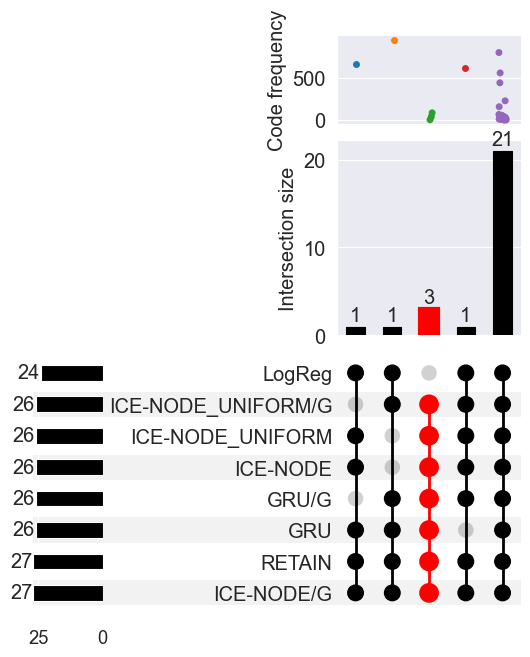

In [27]:
upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg', 
              'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']

m3_code_attrs = {'Code frequency': m3_interface.dx_flatccs_frequency(m3_train_ids)}

m3_upset_result = A.relative_performance_upset(auctests_m3, upset_clfs, 
                                               code_attrs=m3_code_attrs,
                                               **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})



with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m3_upset_result['indicator_df'], data=m3_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(absent=['LogReg'], present=('ICE-NODE', 'GRU', 'RETAIN'),
                               facecolor="red",
                               edgecolor="red", linewidth=3)
    upset_object.add_catplot(value='Code frequency', kind="strip")
    
    g = upset_object.plot()
        
    current_figure = plt.gcf()
    w, h = 2.5, 3
    wi, hi = current_figure.get_size_inches()
    current_figure.set_size_inches(hi*(w/h), hi)
    current_figure.savefig(f"{output_dir}/upset_M3.pdf", bbox_inches='tight')
    plt.show()

In [28]:
results_m3_eval,_ = A.evaluation_table(test_res_m3, m3_train_percentiles, top_k_list=top_k_list)

In [29]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G',
              'ICE-NODE', 
              'ICE-NODE/G'
              )
results_m3_tables = A.top_k_tables(table_clfs, results_m3_eval, top_k_list=top_k_list,
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M3')

,ACC-P0-k1,ACC-P1-k1,ACC-P2-k1,ACC-P3-k1,ACC-P4-k1
LogReg,0.043,0.097,0.048,0.070,0.102
RETAIN,0.033,0.075,0.068,0.063,0.153
GRU,0.040,0.071,0.059,0.067,0.138
GRU/G,0.037,0.069,0.064,0.059,0.148
ICE-NODE_UNIFORM,0.028,0.076,0.062,0.052,0.180
ICE-NODE_UNIFORM/G,0.032,0.072,0.071,0.050,0.173
ICE-NODE,0.031,0.073,0.068,0.048,0.174
ICE-NODE/G,0.032,0.071,0.071,0.049,0.175


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k1} & {ACC-P1-k1} & {ACC-P2-k1} & {ACC-P3-k1} & {ACC-P4-k1} \\
\texttt{LogReg} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.043 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.097 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.048 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.070 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.102 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.033 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.075 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.068 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.063 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.153 \\
\texttt{GRU} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.040 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.071 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.059 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.067 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.138 \\
\textt

,ACC-P0-k2,ACC-P1-k2,ACC-P2-k2,ACC-P3-k2,ACC-P4-k2
LogReg,0.064,0.155,0.104,0.162,0.198
RETAIN,0.052,0.131,0.128,0.127,0.288
GRU,0.067,0.123,0.114,0.128,0.265
GRU/G,0.056,0.125,0.120,0.125,0.282
ICE-NODE_UNIFORM,0.053,0.126,0.111,0.134,0.316
ICE-NODE_UNIFORM/G,0.057,0.128,0.124,0.124,0.315
ICE-NODE,0.053,0.127,0.122,0.124,0.311
ICE-NODE/G,0.056,0.127,0.123,0.124,0.317


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k2} & {ACC-P1-k2} & {ACC-P2-k2} & {ACC-P3-k2} & {ACC-P4-k2} \\
\texttt{LogReg} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.064 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.155 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.104 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.162 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.198 \\
\texttt{RETAIN} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.052 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.131 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.128 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.127 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.288 \\
\texttt{GRU} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.067 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.123 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.114 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.128 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.265 \\
\textt

,ACC-P0-k3,ACC-P1-k3,ACC-P2-k3,ACC-P3-k3,ACC-P4-k3
LogReg,0.081,0.198,0.162,0.214,0.291
RETAIN,0.072,0.168,0.173,0.197,0.411
GRU,0.087,0.155,0.166,0.195,0.378
GRU/G,0.076,0.163,0.166,0.201,0.395
ICE-NODE_UNIFORM,0.074,0.163,0.168,0.208,0.442
ICE-NODE_UNIFORM/G,0.071,0.164,0.171,0.202,0.438
ICE-NODE,0.075,0.167,0.175,0.200,0.439
ICE-NODE/G,0.073,0.164,0.176,0.198,0.433


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k3} & {ACC-P1-k3} & {ACC-P2-k3} & {ACC-P3-k3} & {ACC-P4-k3} \\
\texttt{LogReg} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.081 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.198 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.162 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.214 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.291 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.072 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.168 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.173 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.197 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.411 \\
\texttt{GRU} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.087 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.155 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.166 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.195 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.378 \\
\textt

,ACC-P0-k5,ACC-P1-k5,ACC-P2-k5,ACC-P3-k5,ACC-P4-k5
LogReg,0.103,0.263,0.248,0.322,0.437
RETAIN,0.109,0.225,0.282,0.320,0.584
GRU,0.116,0.215,0.244,0.346,0.556
GRU/G,0.107,0.217,0.251,0.350,0.571
ICE-NODE_UNIFORM,0.102,0.221,0.259,0.345,0.608
ICE-NODE_UNIFORM/G,0.103,0.221,0.263,0.338,0.603
ICE-NODE,0.104,0.226,0.268,0.337,0.601
ICE-NODE/G,0.102,0.219,0.262,0.339,0.604


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k5} & {ACC-P1-k5} & {ACC-P2-k5} & {ACC-P3-k5} & {ACC-P4-k5} \\
\texttt{LogReg} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.103 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.263 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.248 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.322 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.437 \\
\texttt{RETAIN} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.109 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.225 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.282 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.320 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.584 \\
\texttt{GRU} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.116 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.215 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.244 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.346 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.556 \\
\textt

,ACC-P0-k7,ACC-P1-k7,ACC-P2-k7,ACC-P3-k7,ACC-P4-k7
LogReg,0.118,0.312,0.330,0.403,0.547
RETAIN,0.142,0.267,0.353,0.450,0.709
GRU,0.141,0.265,0.318,0.470,0.673
GRU/G,0.125,0.268,0.318,0.485,0.689
ICE-NODE_UNIFORM,0.126,0.277,0.327,0.476,0.729
ICE-NODE_UNIFORM/G,0.128,0.272,0.334,0.456,0.718
ICE-NODE,0.140,0.275,0.339,0.462,0.715
ICE-NODE/G,0.125,0.270,0.337,0.460,0.715


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k7} & {ACC-P1-k7} & {ACC-P2-k7} & {ACC-P3-k7} & {ACC-P4-k7} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.118 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.312 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.330 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.403 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.547 \\
\texttt{RETAIN} & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.142 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.267 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.353 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.450 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.709 \\
\texttt{GRU} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.141 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.265 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.318 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.470 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.673 \\
\textt

,ACC-P0-k10,ACC-P1-k10,ACC-P2-k10,ACC-P3-k10,ACC-P4-k10
LogReg,0.141,0.385,0.419,0.500,0.661
RETAIN,0.168,0.336,0.444,0.607,0.823
GRU,0.165,0.317,0.423,0.613,0.789
GRU/G,0.156,0.326,0.422,0.620,0.805
ICE-NODE_UNIFORM,0.166,0.341,0.432,0.633,0.818
ICE-NODE_UNIFORM/G,0.161,0.333,0.432,0.618,0.812
ICE-NODE,0.175,0.342,0.442,0.627,0.811
ICE-NODE/G,0.159,0.334,0.436,0.618,0.813


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k10} & {ACC-P1-k10} & {ACC-P2-k10} & {ACC-P3-k10} & {ACC-P4-k10} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.141 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.385 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.419 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.500 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.661 \\
\texttt{RETAIN} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.168 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.336 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.444 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.607 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.823 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.165 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.317 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.423 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.613 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.789 \\
\

,ACC-P0-k15,ACC-P1-k15,ACC-P2-k15,ACC-P3-k15,ACC-P4-k15
LogReg,0.164,0.454,0.544,0.683,0.777
RETAIN,0.208,0.415,0.579,0.778,0.926
GRU,0.214,0.400,0.556,0.768,0.900
GRU/G,0.204,0.403,0.546,0.778,0.906
ICE-NODE_UNIFORM,0.211,0.422,0.566,0.786,0.909
ICE-NODE_UNIFORM/G,0.206,0.419,0.565,0.782,0.907
ICE-NODE,0.219,0.425,0.578,0.782,0.902
ICE-NODE/G,0.205,0.421,0.569,0.782,0.907


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k15} & {ACC-P1-k15} & {ACC-P2-k15} & {ACC-P3-k15} & {ACC-P4-k15} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.164 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.454 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.544 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.683 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.777 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.208 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.415 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.579 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.778 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.926 \\
\texttt{GRU} & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.214 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.400 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.556 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.768 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.900 \\
\

,ACC-P0-k20,ACC-P1-k20,ACC-P2-k20,ACC-P3-k20,ACC-P4-k20
LogReg,0.183,0.525,0.647,0.798,0.848
RETAIN,0.245,0.487,0.690,0.877,0.967
GRU,0.248,0.478,0.660,0.859,0.954
GRU/G,0.236,0.465,0.663,0.864,0.953
ICE-NODE_UNIFORM,0.258,0.506,0.670,0.861,0.945
ICE-NODE_UNIFORM/G,0.243,0.501,0.677,0.859,0.944
ICE-NODE,0.265,0.504,0.675,0.854,0.943
ICE-NODE/G,0.243,0.501,0.673,0.858,0.944


\begin{tabular}{lrrrrr}
{} & {ACC-P0-k20} & {ACC-P1-k20} & {ACC-P2-k20} & {ACC-P3-k20} & {ACC-P4-k20} \\
\texttt{LogReg} & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.183 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.525 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.647 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.798 & {\cellcolor[HTML]{8E0152}} \color[HTML]{F1F1F1} 0.848 \\
\texttt{RETAIN} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.245 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.487 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.690 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.877 & {\cellcolor[HTML]{276419}} \color[HTML]{F1F1F1} 0.967 \\
\texttt{GRU} & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.248 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.478 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.660 & {\cellcolor[HTML]{F7F7F6}} \color[HTML]{000000} 0.859 & {\cellcolor[HTML]{9ACD61}} \color[HTML]{000000} 0.954 \\
\

In [30]:
competing_tests_df = auctests_m3[auctests_m3.CODE_INDEX.isin(m3_upset_result['indicator_df'][m3_upset_result['indicator_df']['LogReg']==False].index)]
competing_tests_df.loc[:, [col for col in competing_tests_df.columns if col[:2]=='P0']]

,P0(AUC_GRU==AUC_GRU/G),P0(AUC_GRU==AUC_ICE-NODE),P0(AUC_GRU==AUC_ICE-NODE/G),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM),P0(AUC_GRU==AUC_ICE-NODE_UNIFORM/G),P0(AUC_GRU==AUC_LogReg),P0(AUC_GRU==AUC_RETAIN),P0(AUC_GRU/G==AUC_ICE-NODE),P0(AUC_GRU/G==AUC_ICE-NODE/G),P0(AUC_GRU/G==AUC_ICE-NODE_UNIFORM),...,P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM),P0(AUC_ICE-NODE/G==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE/G==AUC_LogReg),P0(AUC_ICE-NODE/G==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM==AUC_ICE-NODE_UNIFORM/G),P0(AUC_ICE-NODE_UNIFORM==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM==AUC_RETAIN),P0(AUC_ICE-NODE_UNIFORM/G==AUC_LogReg),P0(AUC_ICE-NODE_UNIFORM/G==AUC_RETAIN),P0(AUC_LogReg==AUC_RETAIN)
7,0.274,0.064,0.051,0.059,0.047,3.589e-02,0.588,0.022,0.015,0.015,...,0.348,0.678,8.898e-01,0.036,0.362,5.910e-01,0.040,8.469e-01,0.032,1.917e-02
129,0.407,0.161,0.417,0.193,0.238,4.051e-02,0.109,0.451,0.772,0.527,...,0.378,0.156,7.461e-03,0.713,0.992,6.013e-03,0.922,5.779e-03,0.919,1.175e-02
135,0.166,0.592,0.408,0.334,0.412,1.721e-07,0.601,0.840,0.892,0.874,...,0.995,0.821,8.183e-05,0.650,0.930,2.707e-05,0.592,6.315e-05,0.669,6.132e-07


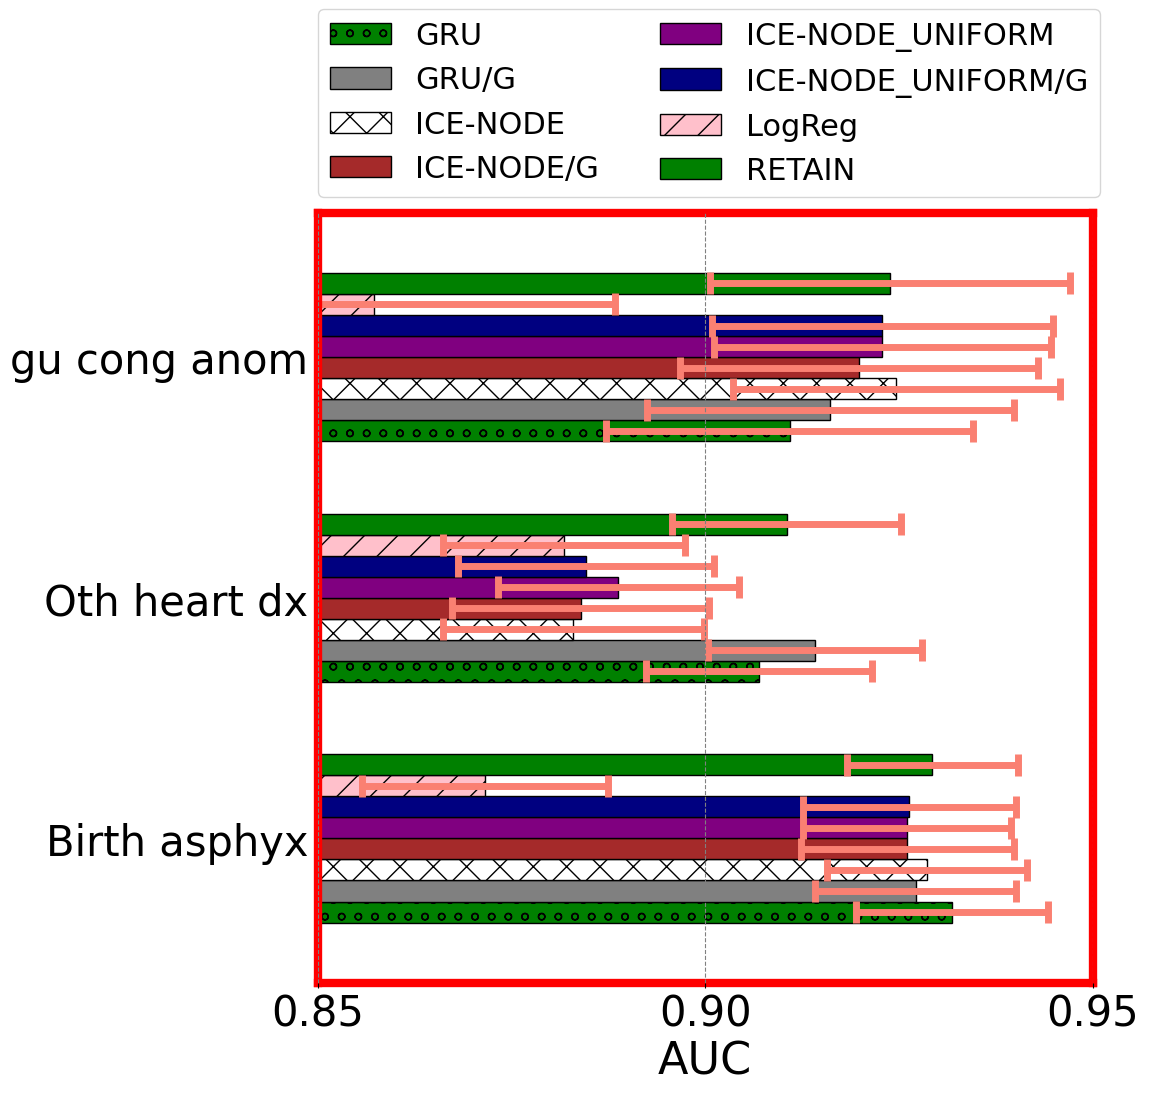

In [31]:
upset_clfs = ['ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
              'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G']

ax = A.selected_auc_barplot(upset_clfs, competing_tests_df,  horizontal=True)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

current_figure = plt.gcf()
# w, h = 4, 4
# wi, hi = current_figure.get_size_inches()
# current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig(f"{output_dir}/icenode_m3.pdf", bbox_inches='tight')
plt.show()


<a name="sec3"></a>

## 3 Relative AUC Performance on MIMIC-IV (Test Set) [^](#outline)

In [32]:
m4_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m4_predictors = {clf: cross_predictor(clf, 'M4', 'M4') for clf in m4_clfs}

In [33]:
test_res_m4 = {clf: C.eval2_(model, m4_test_ids) for clf, model in m4_predictors.items()} 

In [ ]:
auctests_m4 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4.items()}, fast=True)


 40%|████████████████████████████████████████████████████████████████▍                                                                                              | 98/242 [03:19<05:00,  2.08s/it]

In [ ]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')
m4_code_attrs = {'Code frequency': m4_interface.dx_flatccs_frequency(m4_train_ids)}

m4_upset_result = A.relative_performance_upset(auctests_m4, upset_clfs, 
                                               code_attrs=m4_code_attrs,
                                               **relative_auc_config)
upset_ctx = lambda : sns.plotting_context("paper",  font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m4_upset_result['indicator_df'], data=m4_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.style_subsets(present=['ICE-NODE'], absent=('ICE-NODE_UNIFORM', 'GRU', 'RETAIN'),
                               edgecolor="red", linewidth=3, facecolor="red")
    upset_object.add_catplot(value='Code frequency', kind="strip")

    g = upset_object.plot()
    current_figure = plt.gcf()
#     w, h = 5, 3
#     wi, hi = current_figure.get_size_inches()
#     current_figure.set_size_inches(hi*(w/h), hi)

    current_figure.savefig(f"{output_dir}/upset_M4.pdf", bbox_inches='tight')
    plt.show()


In [ ]:
results_m4_eval, _ = A.evaluation_table(test_res_m4, m4_train_percentiles, top_k_list=top_k_list)

In [ ]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              )
results_m4_tables = A.top_k_tables(table_clfs, results_m4_eval, top_k_list=top_k_list, 
                                   n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4')

In [ ]:
icenode_m4_excl = m4_upset_result['content_sets']['ICE-NODE'] - set.union(*list(m4_upset_result['content_sets'][clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4_excl = m4_upset_result['competing_performance'][m4_upset_result['competing_performance']['CODE_INDEX'].isin(icenode_m4_excl)]
icenode_m4_excl

In [ ]:
# icenode_ratain_gru_m4 = upsetcontents_m4['ICE-NODE']
# icenode_ratain_gru_m4 = compete_codesm4[compete_codesm4['CODE_INDEX'].isin(icenode_ratain_gru_m4)]
# icenode_ratain_gru_m4.sort_values('AUC(ICE-NODE)', ascending=False)[['CODE_INDEX', 'N_POSITIVE_CODES', 'DESC', 'AUC(ICE-NODE)']]

In [ ]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg')
w, h = 4, 3
ax = A.selected_auc_barplot(upset_clfs, icenode_m4_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(-0.02, 1), ncol=2)
current_figure = plt.gcf()
w, h = 4, 4
wi, hi = current_figure.get_size_inches()
current_figure.set_size_inches(hi*(w/h), hi)

current_figure.savefig(f"{output_dir}/icenode_m4.pdf", bbox_inches='tight')
plt.show()


<a name="sec4"></a>

## 4 Relative AUC Performance From MIMIC-IV (Training Set) to MIMIC-III (All) [^](#outline)

In [ ]:
m4m3_clfs =  ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',
                'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

# clfs_ordered = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN')
m3_subjects = list(m3_interface.subjects.keys())
m4m3_predictors = {clf: cross_predictor(clf, 'M4', 'M3') for clf in m4m3_clfs}

In [ ]:
test_res_m4m3 = {clf: C.eval2_(model, m3_subjects) for clf, model in m4m3_predictors.items()} 

In [ ]:
auctests_m4m3 = A.codes_auc_pairwise_tests({k: v['risk_prediction'] for k, v in test_res_m4m3.items()}, fast=True)

In [ ]:
upset_clfs = ('ICE-NODE', 'ICE-NODE_UNIFORM', 'GRU', 'RETAIN', 'LogReg',)
#                 'ICE-NODE/G', 'ICE-NODE_UNIFORM/G', 'GRU/G')

m4m3_code_attrs = {'Code frequency': m4_interface.dx_flatccs_frequency(m4_train_ids)}

m4m3_upset_result = A.relative_performance_upset(auctests_m4m3, upset_clfs, 
                                                 code_attrs=m4m3_code_attrs,
                                                 **relative_auc_config)

upset_ctx = lambda : sns.plotting_context("paper", font_scale=1.5, rc={"font.family": "Loma", 
                                                                        'axes.labelsize': 'medium',
                                                                       'ytick.labelsize': 'medium'})
with sns.axes_style("darkgrid"), upset_ctx():
    upset_format = from_indicators(m4m3_upset_result['indicator_df'], data=m4m3_upset_result['data'])
    upset_object = UpSet(upset_format, subset_size='count', show_counts=True)
    upset_object.add_catplot(value='Code frequency', kind="strip")

    upset_object.style_subsets(present='ICE-NODE', absent=['ICE-NODE_UNIFORM', 'GRU', 'RETAIN'],
                              edgecolor="red", facecolor="red")
    g = upset_object.plot()
    
    current_figure = plt.gcf()
    current_figure.savefig(f"{output_dir}/upset_M4M3.pdf", bbox_inches='tight')
    plt.show()

In [ ]:
results_m4m3_eval, _ = A.evaluation_table(test_res_m4m3, m4_train_percentiles, top_k_list=top_k_list)

In [ ]:
table_clfs = ('LogReg', 
              'RETAIN',
              'GRU',
              'GRU/G',
              'ICE-NODE', 
              'ICE-NODE/G',
              'ICE-NODE_UNIFORM',
              'ICE-NODE_UNIFORM/G'
              )

results_m4m3_tables = A.top_k_tables(table_clfs, results_m4m3_eval, top_k_list=top_k_list, 
                                     n_percentiles=n_percentiles, out_prefix=f'{output_dir}/M4M3')

In [ ]:
icenode_m4m3_excl = m4m3_upset_result['content_sets']['ICE-NODE'] - set.union(*list(m4m3_upset_result['content_sets'][clf] for clf in ('RETAIN', 'GRU', 'ICE-NODE_UNIFORM')))
icenode_m4m3_excl = compete_codesm4m3[m4m3_upset_result['competing_performance']['CODE_INDEX'].isin(icenode_m4m3_excl)]
icenode_m4m3_excl

In [ ]:
ax = A.selected_auc_barplot(upset_clfs, icenode_m4m3_excl, horizontal=True)

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
# ax.legend(fontsize=22, title_fontsize=32,
#           bbox_to_anchor=(0.02, 1), ncol=2)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
ax.legend(fontsize=22, title_fontsize=32,
          bbox_to_anchor=(1, 1.25), ncol=2)

current_figure = plt.gcf()
current_figure.savefig(f"{output_dir}/icenode_m4m3.pdf", bbox_inches='tight')
plt.show()


## Trajectories for Patients with CCS codes best predicted with ICENODE

### Analyse AUC for Each Admission in the Test Partition

In [34]:
def admissions_auc_scores(model, test_ids):
    model, state = model
    return model.admissions_auc_scores(state, test_ids)

In [35]:
m4_icenode_visit_auc_df = admissions_auc_scores(m4_predictors['ICE-NODE'], m4_test_ids)
m4_icenode_visit_auc_df['N_VISITS'] = m4_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())

In [36]:
m4_visit_auc_subject = m4_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min'] })

In [37]:
m4m3_icenode_visit_auc_df = admissions_auc_scores(m4m3_predictors['ICE-NODE'], m3_interface.subjects.keys())
m4m3_icenode_visit_auc_df['N_VISITS'] = m4m3_icenode_visit_auc_df['SUBJECT_ID'].apply(lambda i: (m4m3_icenode_visit_auc_df['SUBJECT_ID'] == i).sum())
m4m3_visit_auc_subject = m4m3_icenode_visit_auc_df.groupby('SUBJECT_ID').agg(
    {'AUC': 'mean', 
     'N_VISITS': 'max', 
     'N_CODES': ['min', 'max', 'mean', 'median'], 
     'INTERVALS': ['mean', 'max', 'min']
    })


In [38]:
m4_best_visit_auc_subjects =  m4_visit_auc_subject[(m4_visit_auc_subject.N_VISITS['max'] > 2) & (m4_visit_auc_subject.INTERVALS['max'] < 150)]
m4m3_best_visit_auc_subjects =  m4m3_visit_auc_subject[(m4m3_visit_auc_subject.N_VISITS['max'] > 1) & (m4m3_visit_auc_subject.INTERVALS['max'] < 150)]


In [39]:
len(m4_best_visit_auc_subjects), len(m4m3_best_visit_auc_subjects)

(365, 220)

In [40]:
m4_ccs_history = {i: m4_interface.dx_flatccs_history(i) for i in m4_best_visit_auc_subjects.index}
m4m3_ccs_history = {i: m3_interface.dx_flatccs_history(i) for i in m4m3_best_visit_auc_subjects.index}

m4_ccs_idx_frequency = m4_interface.dx_flatccs_frequency(list(m4_best_visit_auc_subjects.index))
m3_ccs_idx_frequency = m3_interface.dx_flatccs_frequency(list(m4m3_best_visit_auc_subjects.index))

In [41]:
m4_history_all_ccs_codes = set(map(C.ccs_dag.dx_flatccs_idx.get, set.union(*[set(h.keys()) for h in m4_ccs_history.values()])))
m3_history_all_ccs_codes = set(map(C.ccs_dag.dx_flatccs_idx.get, set.union(*[set(h.keys()) for h in m4m3_ccs_history.values()])))
m4_history_all_ccs_codes = {idx for idx in m4_history_all_ccs_codes if m4_ccs_idx_frequency[idx] < 10}
m3_history_all_ccs_codes = {idx for idx in m3_history_all_ccs_codes if m3_ccs_idx_frequency[idx] < 10}

len(m4_history_all_ccs_codes), len(m3_history_all_ccs_codes)

(51, 74)

In [42]:
icenode_m4_competent = upsetcontents_m4['ICE-NODE'] 
icenode_m4_competent = auctests_m4[auctests_m4['CODE_INDEX'].isin(icenode_m4_competent)]
icenode_m4_competent = icenode_m4_competent[['N_POSITIVE_CODES', 'AUC(ICE-NODE)', 'DESC']].sort_values('N_POSITIVE_CODES',ascending=False)
# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]
icenode_m4_competent[icenode_m4_competent.index.isin(trajectory_ccs_codes_level2)]

,N_POSITIVE_CODES,AUC(ICE-NODE),DESC
173,1790.0,0.941892,Non-Hodg lym
168,520.0,0.951321,Kidny/rnl ca
216,244.0,0.974325,Meningitis
169,181.0,0.942847,Uriny org ca
156,148.0,0.965231,Uterus cancr
165,146.0,0.957154,Testis cancr
171,89.0,0.940833,Thyroid cncr
100,84.0,0.952710,Brnch/lng ca
167,67.0,0.957488,Bladder cncr


In [43]:
trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
]


In [44]:
m4_ccs_history_level1 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}
m4m3_ccs_history_level1 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level1)) & set(history.keys())) > 0}

m4_ccs_history_level2 = {i: history for i, history in m4_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}
m4m3_ccs_history_level2 = {i: history for i, history in m4m3_ccs_history.items() 
                         if len(set(map(A.dx_flatccs_idx2code.get, trajectory_ccs_codes_level2)) & set(history.keys())) > 0}

In [45]:
len(m4_ccs_history_level1), len(m4m3_ccs_history_level1), len(m4_ccs_history_level2), len(m4m3_ccs_history_level2) 


(180, 115, 68, 35)

In [46]:
m4_cases = set(m4_ccs_history_level1.keys()) | set(m4_ccs_history_level2.keys())
m4m3_cases = set(m4m3_ccs_history_level1.keys()) | set(m4m3_ccs_history_level2.keys())
len(m4_cases), len(m4m3_cases)

(206, 131)

In [47]:
m4_icenode, m4_icenode_state = m4_predictors['ICE-NODE']
m4_trajectory = m4_icenode.sample_trajectory(m4_icenode_state, m4_cases, 1)

  0%|                                                    | 0/22 [00:00<?, ?it/s]/home/asem/GP/ICENODE/notebooks/../icenode/ehr_predictive/dx_icenode_tl.py:412: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pos[[top10_idx]] = 1
100%|███████████████████████████████████████████| 22/22 [34:49<00:00, 94.97s/it]


In [48]:
m4m3_icenode, m4m3_icenode_state = m4m3_predictors['ICE-NODE']
m4m3_trajectory = m4m3_icenode.sample_trajectory(m4m3_icenode_state, m4m3_cases, 1)

100%|█████████████████████████████████████████████| 9/9 [12:57<00:00, 86.38s/it]


In [49]:
# m4_selected_subjects = [
#     13798593, #acute-renal
#     13965528, #acute-renal
#     11907876, #pulmonary heart dx
#     13557547, #ear dx
#     10139504, #acute renal fail
#     12367864, #pulomonary-heart dx
# ]

# m4_selected_trajectory = {i: m4_trajectory[i] for i in m4_selected_subjects}

# m3_selected_subjects = [
#     50093 #pulmonary-heart dx
# ]

# m3_selected_trajectory = {i: m4m3_trajectory[i] for i in m3_selected_subjects}


In [174]:
import random

trajectory_ccs_codes_level1 = [
    64, #renal fail 
    6, # pulm heart dx
    236, # ear dx 
    # Others
    100, # Brnch/lng ca
    168, # Kidney/rnl ca
    194, # Immunity dx
]



# icenode_m4_competent.head(50)
trajectory_ccs_codes_level2 = [
    173, 168, 169, 156, 165, 216, 171, 100, 167
]

random.seed(42)
ccs_color = {
    6: 'blue',
    64: 'purple',
    236: 'orange',
    # Others
    100: 'salmon', # Brnch/lng ca
    168: 'navy', # Kidney/rnl ca
    194: 'pink', # Immunity dx
    **{idx: "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                   for idx in trajectory_ccs_codes_level2}
}


plt.rcParams['figure.figsize'] = (10, 7)



In [183]:
plt.close('all')
for data_label, interface, trajectory_set in zip(["M4", "M3"], [m4_interface, m3_interface], [m4_trajectory, m4m3_trajectory]):
    for indices_label, ccs_indices in zip(["L1", "L2", "L1UL2"], [trajectory_ccs_codes_level1, trajectory_ccs_codes_level2, trajectory_ccs_codes_level1 + trajectory_ccs_codes_level2]):
        out_dir = f'{output_dir}/trajectories/{data_label}_{indices_label}' 
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        A.plot_trajectory(trajectories=trajectory_set, 
                          interface=interface, 
                          flatccs_selection=ccs_indices, 
                          ccs_color=ccs_color,
                          out_dir=out_dir)

/home/asem/GP/ICENODE/notebooks/analysis.py:443: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)
